In [1]:
import sys
import numpy as np
import pandas as pd
import catboost as cbt
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss,precision_score, recall_score, f1_score 
import gc
import math
import time
from tqdm import tqdm
import datetime
from sklearn.model_selection import KFold,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import warnings
import os
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
train = pd.read_csv(r'C:\Users\12239\Desktop\CFF\离散制造过程中典型工件的质量符合率预测\train_set\first_round_training_data - 副本.csv')
test = pd.read_csv(r'C:\Users\12239\Desktop\CFF\离散制造过程中典型工件的质量符合率预测\test_set\first_round_testing_data - 副本.csv')
submit = pd.read_csv(r'C:\Users\12239\Desktop\CFF\离散制造过程中典型工件的质量符合率预测\submit_example.csv')

In [3]:
quality_map = {'Excellent': 0, 'Good': 1, 'Pass': 2, 'Fail': 3}
train['label'] = train['Quality_label'].map(quality_map)
# 将标签onehot编码，方便管理和统计。
# idea1：可以考虑做4个二分类，或者尝试使用mae 做loss 或者mse 做loss，并观察结果的分布以及线下得分。
train = pd.get_dummies(train, columns=['Quality_label'])
bin_label = ['Quality_label_Excellent', 'Quality_label_Good', 'Quality_label_Pass', 'Quality_label_Fail']
data = pd.concat([train, test], ignore_index=True)
data['id'] = data.index

In [4]:
# 因为1，属性特征目测是连续特征，2，数值大小分布差异过大，所以将属性做log变换之后做处理，会更合适一些。也可以考虑分桶处理
# 为什么做log变换更合理呢？试想一下，假如统计一个人某个数值属性，发现是如下的一个列表[1,2,1.1,1.5,20],
# 这种场景分布偏差较大的情况下，如果取均值作为特征，是否合适？
# 再比如，如果预测一组数值，一条极端数据对结果的影响超过了N多的数据，这样的模型是否是一个好的模型？
# 参数特征这里使用5-10
para_feat = ['Parameter{0}'.format(i) for i in range(5, 11)]
# 属性特征
attr_feat = ['Attribute{0}'.format(i) for i in range(1, 11)]
data[attr_feat] = np.log1p(data[attr_feat])
# or data[attr_feat] = np.log10(data[attr_feat] + 1)
# 此时绘图观察分布显得合理很多
#for i in attr_feat:
#    data[i].hist()
#    plt.show()

In [5]:
# 使用预测属性的model去预测属性，
# 1、测试集没有属性，该怎么用？当然是预测它了。预测的方法，可以由模型获得
# 2、训练集的属性怎么用？既然测试集的属性是预测出来的，训练集也应该用同等性质的属性，也就是5折交叉预测出来的属性。
# 3、第一次想到该方法于2018年的光伏预测赛中，首见成效，之后教与ration（for free），后在icme中，也用到类似方法。
# 4、该方法带来的提升目前不太稳定。6750 -- 6800。
def get_predict_w(model, data, label='label', feature=[], cate_feature=[], random_state=2018, n_splits=5,model_type='lgb'):
    if 'sample_weight' not in data.keys():
        data['sample_weight'] = 1
    model.random_state = random_state
    predict_label = 'predict_' + label
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    data[predict_label] = 0
    test_index = (data[label].isnull()) | (data[label] == -1)
    train_data = data[~test_index].reset_index(drop=True)
    test_data = data[test_index]
    for train_idx, val_idx in kfold.split(train_data):
        model.random_state = model.random_state + 1
        train_x = train_data.loc[train_idx][feature]
        train_y = train_data.loc[train_idx][label]
        test_x = train_data.loc[val_idx][feature]
        test_y = train_data.loc[val_idx][label]
        if model_type == 'lgb':
            try:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',categorical_feature=cate_feature,
                          sample_weight=train_data.loc[train_idx]['sample_weight'],verbose=100)
            except:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',sample_weight=train_data.loc[train_idx]['sample_weight'],
                          verbose=100)# categorical_feature=cate_feature,        
        elif model_type == 'ctb':
            model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                      eval_metric='mae',cat_features=cate_feature,
                      sample_weight=train_data.loc[train_idx]['sample_weight'],verbose=100)
            train_data.loc[val_idx, predict_label] = model.predict(test_x)
        if len(test_data) != 0:
            test_data[predict_label] = test_data[predict_label] + model.predict(test_data[feature])
    test_data[predict_label] = test_data[predict_label] / n_splits
    return pd.concat([train_data, test_data], sort=True, ignore_index=True), predict_label

In [6]:
lgb_attr_model = lgb.LGBMRegressor(boosting_type="gbdt", num_leaves=31, reg_alpha=10, reg_lambda=5,
                                   max_depth=7, n_estimators=500,subsample=0.7, colsample_bytree=0.4, 
                                   subsample_freq=2, min_child_samples=10,learning_rate=0.05, random_state=2019,)
features = para_feat
for i in attr_feat:
    data, predict_label = get_predict_w(lgb_attr_model, data, label=i,feature=features, random_state=2019, n_splits=5)
    print(predict_label, 'done!!')
# 该方案共获得10个属性特征。
pred_attr_feat = ['predict_Attribute{0}'.format(i) for i in range(1, 11)]

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2.37377	valid_0's l2: 9.52422
Early stopping, best iteration is:
[1]	valid_0's l1: 2.34643	valid_0's l2: 9.2934
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2.33934	valid_0's l2: 8.85975
Early stopping, best iteration is:
[1]	valid_0's l1: 2.31538	valid_0's l2: 8.6738
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2.19348	valid_0's l2: 7.79823
Early stopping, best iteration is:
[1]	valid_0's l1: 2.17014	valid_0's l2: 7.60857
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2.20048	valid_0's l2: 7.81575
Early stopping, best iteration is:
[1]	valid_0's l1: 2.18997	valid_0's l2: 7.69738
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2.33737	valid_0's l2: 9.26249
Early stopping, best iteration is:
[1]	valid_0's l1: 2.30448	valid_0's l2: 8.97287
predict_Attribute1 don

Did not meet early stopping. Best iteration is:
[454]	valid_0's l1: 0.814383	valid_0's l2: 1.54842
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.873775	valid_0's l2: 1.58469
[200]	valid_0's l1: 0.848502	valid_0's l2: 1.52482
[300]	valid_0's l1: 0.841463	valid_0's l2: 1.49858
[400]	valid_0's l1: 0.840252	valid_0's l2: 1.49273
[500]	valid_0's l1: 0.838946	valid_0's l2: 1.48806
Did not meet early stopping. Best iteration is:
[469]	valid_0's l1: 0.837289	valid_0's l2: 1.48654
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.917841	valid_0's l2: 2.02409
[200]	valid_0's l1: 0.900398	valid_0's l2: 1.96267
[300]	valid_0's l1: 0.896537	valid_0's l2: 1.93422
[400]	valid_0's l1: 0.893352	valid_0's l2: 1.91474
[500]	valid_0's l1: 0.891801	valid_0's l2: 1.91018
Did not meet early stopping. Best iteration is:
[497]	valid_0's l1: 0.891312	valid_0's l2: 1.90931
predict_Attribute6 done!!
Training until validation scores don't im

In [47]:
k = 5
boosttype = 'xgb'
feature_name = pred_attr_feat + para_feat#选取特征
tr_index = ~data['label'].isnull()#将data中label这一列不为空的行数选取出来
data[tr_index][pred_attr_feat] = data[tr_index][attr_feat]
X_train = data[tr_index][feature_name].reset_index(drop=True)#用tr_index选出trainset
y = data[tr_index]['label'].reset_index(drop=True).astype(int)#label of trainset
X_test = data[~tr_index][feature_name].reset_index(drop=True)#用tr_index的取反得到testset

print(X_train.shape,X_test.shape)
oof = np.zeros((X_train.shape[0],4))
prediction = np.zeros((X_test.shape[0],4))
seeds = [x*x for x in range(100,200,20)]#设置随机种子
num_model_seed = len(seeds)
#params = {'max_depth':range(2, 7), 'n_estimators':range(100, 1100, 200), 'learning_rate':[0.01]}

for model_seed in range(num_model_seed):
    print(model_seed + 1)
    oof_model = np.zeros((X_train.shape[0],4))
    prediction_model=np.zeros((X_test.shape[0],4))
#    oof_xgb = np.zeros((X_train.shape[0],4))
#    prediction_xgb=np.zeros((X_test.shape[0],4))
    skf = StratifiedKFold(n_splits=k, random_state=seeds[model_seed], shuffle=True)#构造交叉验证集，进行按比例取样（splits表示测试集和验证集为4：1）
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        print(index)
        train_x, test_x, train_y, test_y = X_train.iloc[train_index], X_train.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        gc.collect()#进行垃圾内存回收
        if boosttype=='cbt':
            model = cbt.CatBoostClassifier(iterations=4000,learning_rate=0.05,verbose=1000,max_depth=6,
                                           early_stopping_rounds=2800,
                                           task_type='GPU',loss_function='MultiClass')
            model.fit(train_x, train_y ,eval_set=(train_x, train_y))
        elif boosttype=='xgb':
            model = XGBClassifier(
            silent=True ,#设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
            #nthread=4,# cpu 线程数 默认最大
            learning_rate= 0.05, # 如同学习率
            min_child_weight=1,
            # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
            #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
            #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
            max_depth=8, # 构建树的深度，越大越容易过拟合
            gamma=0.1,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
            subsample=1, # 随机采样训练样本 训练实例的子采样比
            max_delta_step=0,#最大增量步长，我们允许每个树的权重估计。
            colsample_bytree=1, # 生成树时进行的列采样
            reg_lambda=1,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
            #reg_alpha=0, # L1 正则项参数
            scale_pos_weight=1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
            objective= 'multi:softmax', #多分类的问题 指定学习任务和相应的学习目标
            num_class=4, # 类别数，多分类与 multisoftmax 并用
            n_estimators=2000, #树的个数
            seed=2019, #随机种子
            eval_metric= 'mlogloss',
            iterations=2000,
            verbose=1000
            )
            model.fit(train_x, train_y,eval_metric='mlogloss')
        elif boosttype=='lgb':
            model=lgb.LGBMClassifier(boosting_type="gbdt",num_leaves=23,reg_alpha=10, reg_lambda=5,max_depth=7,
                                 learning_rate=0.05, n_estimators=2000,colsample_bytree=0.7, subsample_freq=1,
                                 objective='multiclass', silent=True,subsample=0.7,min_child_samples=5,
                                 #reg_alpha=1.,bagging_fraction=0.9, feature_fraction=0.9,
                                 )
            model.fit(train_x, train_y, eval_set=(test_x, test_y),early_stopping_rounds=3000, verbose=1000,)#verbose=False   
        oof_model[test_index] = oof_model[test_index]+model.predict_proba(test_x) #预测验证集上某一个工件lebal为0到3的各自概率
        prediction_model = prediction_model+model.predict_proba(X_test)/k #预测测试集上某一个工件lebal为0到3的各自概率（除10是因为splits=10，故要进行10次轮换交叉验证）
    oof = oof+oof_model / num_model_seed
    prediction =prediction+prediction_model / num_model_seed

    print('logloss',log_loss(pd.get_dummies(y).values, oof_model))
    print('ac',accuracy_score(y, np.argmax(oof_model,axis=1)))
    print('mae',1/(1 + np.sum(np.absolute(np.eye(4)[y] - oof_model))/480))

print('logloss',log_loss(pd.get_dummies(y).values, oof))
print('ac',accuracy_score(y, np.argmax(oof,axis=1)))
print('mae',1/(1 + np.sum(np.absolute(np.eye(4)[y] - oof))/480))
beta=2
p1=precision_score(y,np.argmax(oof,axis=1),average='micro')
r1=recall_score(y,np.argmax(oof,axis=1),average='micro')
p2=precision_score(y,np.argmax(oof,axis=1),average='macro')
r2=recall_score(y,np.argmax(oof,axis=1),average='macro')
print('micro precision',p1)
print('micro recall',r1)
print('macro precision',p2)
print('macro recall',r2)
print('micro F2-Score',(1+beta*beta)*p1*r1/(beta*beta*p1+r1))
print('macro F2-Score',(1+beta*beta)*p2*r2/(beta*beta*p2+r2))

(6000, 16) (6000, 16)
1
0
1
2
3
4
logloss 1.239479984100655
ac 0.5068333333333334
mae 0.06658805119623377
2
0
1
2
3
4
logloss 1.269550215100713
ac 0.5036666666666667
mae 0.06680875283835168
3
0
1
2
3
4
logloss 1.2569207008868917
ac 0.5015
mae 0.06672830837792856
4
0
1
2
3
4
logloss 1.249085385095412
ac 0.5075
mae 0.06677955916246239
5
0
1
2
3
4
logloss 1.2593278791629172
ac 0.49866666666666665
mae 0.06675208495447135
logloss 1.1894041102609556
ac 0.5151666666666667
mae 0.06673126341778068
micro precision 0.5151666666666667
micro recall 0.5151666666666667
macro precision 0.4816454908973167
macro recall 0.4695703693172557
micro F2-Score 0.5151666666666667
macro F2-Score 0.47193671273458854


In [12]:
feature_name = pred_attr_feat + para_feat#选取特征
tr_index = ~data['label'].isnull()#将data中label这一列不为空的行数选取出来
data[tr_index][pred_attr_feat] = data[tr_index][attr_feat]
X_train = data[tr_index][feature_name].reset_index(drop=True)#用tr_index选出trainset
y = data[tr_index]['label'].reset_index(drop=True).astype(int)#label of trainset
#y = data[tr_index]['label'].reset_index(drop=True).astype(int)#label of trainset
#y = data[tr_index]['Attribute1'].reset_index(drop=True).astype(float)
X_test = data[~tr_index][feature_name].reset_index(drop=True)#用tr_index的取反得到testset

print(X_train.shape,X_test.shape)
oof = np.zeros((X_train.shape[0],4))
prediction = np.zeros((X_test.shape[0],4))
#seeds = [1000,3000,10000,30000,100000]#设置随机种子
#num_model_seed = 9
#params = {'max_depth':range(2, 7), 'n_estimators':range(100, 1100, 200), 'learning_rate':[0.01]}
#for model_seed in range(num_model_seed):
#    print(model_seed + 1)
#    oof_cat = np.zeros((X_train.shape[0],4))
#    prediction_cat=np.zeros((X_test.shape[0],4))
#    oof_xgb = np.zeros((X_train.shape[0],4))
#    prediction_xgb=np.zeros((X_test.shape[0],4))
#    skf = StratifiedKFold(n_splits=5, random_state=seeds[model_seed], shuffle=True)#构造交叉验证集，进行按比例取样（splits=10表示测试集和验证集为4：1）
#    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
#        print(index)
#        train_x, test_x, train_y, test_y = X_train.iloc[train_index], X_train.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
#        gc.collect()#进行垃圾内存回收
cbt_model = cbt.CatBoostClassifier(iterations=2000,learning_rate=0.01,verbose=1000,
                                   early_stopping_rounds=1800,task_type='GPU',loss_function='MultiClass',
                                   ) #loss_function='MultiClass'
#        xgb_model = GridSearchCV(XGBClassifier(),params,n_jobs=-1, cv=5, verbose=300,refit=True)
#        cbt_model.fit(train_x, train_y ,eval_set=(train_x, train_y))#求一些方差、标准差、最大值和最小值
#cbt_model.fit(X_train, y ,eval_set=(X_train, y))#求一些方差、标准差、最大值和最小值    
cbt_model.fit(X_train, y,eval_set=(X_train, y))#求一些方差、标准差、最大值和最小值
    #        oof_cat[test_index] += cbt_model.predict_proba(test_x)#预测验证集上某一个工件lebal为0到3的各自概率
    #        prediction_cat += cbt_model.predict_proba(X_test)/10#预测测试集上某一个工件lebal为0到3的各自概率（除10是因为splits=10，故要进行10次轮换交叉验证）
    #    oof += oof_cat / num_model_seed
    #    prediction += prediction_cat / num_model_seed
    #        xgb_model.fit(train_x, train_y)
    #        oof_xgb[test_index] += xgb_model.predict_proba(test_x)
    #        prediction_xgb += xgb_model.predict_proba(X_test)/5
    #    oof += oof_xgb / num_model_seed
    #    prediction += prediction_xgb / num_model_seed
    #    print('logloss',log_loss(pd.get_dummies(y).values, oof_cat))
    #    print('ac',accuracy_score(y, np.argmax(oof_cat,axis=1)))
    #    print('mae',1/(1 + np.sum(np.absolute(np.eye(4)[y] - oof_cat))/480))
oof = cbt_model.predict_proba(X_train)
prediction = cbt_model.predict_proba(X_test)
#oof = cbt_model.predict(X_train)
#prediction = cbt_model.predict(X_test)
gc.collect()
#print('logloss',log_loss(pd.get_dummies(y).values, oof))
#print('ac',accuracy_score(y, np.argmax(oof,axis=1)))
#print('mae',1/(1 + np.sum(np.absolute(np.eye(4)[y] - oof))/480))
print('logloss',log_loss(pd.get_dummies(y).values, oof))
print('ac',accuracy_score(y, np.argmax(oof,axis=1)))
print('mae',1/(1 + np.sum(np.absolute(np.eye(4)[y] - oof))/480))
beta=2
p1=precision_score(y,np.argmax(oof,axis=1),average='micro')
r1=recall_score(y,np.argmax(oof,axis=1),average='micro')
p2=precision_score(y,np.argmax(oof,axis=1),average='macro')
r2=recall_score(y,np.argmax(oof,axis=1),average='macro')
print('micro precision',p1)
print('micro recall',r1)
print('macro precision',p2)
print('macro recall',r2)
print('micro F2-Score',(1+beta*beta)*p1*r1/(beta*beta*p1+r1))
print('macro F2-Score',(1+beta*beta)*p2*r2/(beta*beta*p2+r2))

(6000, 16) (6000, 16)
0:	learn: -1.3813354	test: -1.3813356	best: -1.3813356 (0)	total: 19.1ms	remaining: 38.2s
1000:	learn: -1.0310777	test: -1.0310777	best: -1.0310777 (1000)	total: 12.8s	remaining: 12.8s
1999:	learn: -0.9836363	test: -0.9836363	best: -0.9836363 (1999)	total: 26s	remaining: 0us
bestTest = -0.9836363118
bestIteration = 1999
Shrink model to first 2000 iterations.
logloss 0.9836364055023246
ac 0.5875
mae 0.06659954131602225
micro precision 0.5875
micro recall 0.5875
macro precision 0.5793030446693477
macro recall 0.536193338552185
micro F2-Score 0.5875
macro F2-Score 0.54429423311743


In [13]:
sub = test[['Group']]#将predications写入到submit_example中
prob_cols = [i for i in submit.columns if i not in ['Group']]
for i, f in enumerate(prob_cols):
    sub[f] = prediction[:, i]
for i in prob_cols:
    sub[i] = sub.groupby('Group')[i].transform('mean')
sub = sub.drop_duplicates()
#sub.to_csv(r'C:\Users\12239\Desktop\CFF\离散制造过程中典型工件的质量符合率预测\submit_example.csv',index=False)

In [14]:
submit = sub.copy()
submit2 = sub.copy()
submit3 = sub.copy()
ratio = ['Excellent ratio','Good ratio','Pass ratio','Fail ratio']
submit[ratio]=submit[ratio]*50
submit2[ratio]=(submit2[ratio]*50).astype('int')
submit3[ratio]=(submit[ratio]-submit2[ratio]).astype('float')
submit2 = submit2.values
submit3 = submit3.values

In [15]:
k = np.argmax(submit3[:,1:5],axis=1) + 1
for i in range(120): 
    if submit3[i,k[i]] > 0.5:
        submit2[i,k[i]] += 1
        submit3[i,k[i]] = 0
k = np.argmax(submit3[:,1:5],axis=1) + 1
for i in range(120):
    if submit3[i,k[i]] > 0.5:
        submit2[i,k[i]] += 1
        submit3[i,k[i]] = 0
k = np.argmax(submit3[:,1:5],axis=1) + 1
for i in range(120):    
    if sum(submit2[i,1:5]) < 50:
        if submit3[i,k[i]] > 0.5:
            submit2[i,k[i]] += 1
            submit3[i,k[i]] = 0
k = np.argmax(submit3[:,1:5],axis=1) + 1
for i in range(120):    
    if sum(submit2[i,1:5]) < 50:
        submit2[i,k[i]] += 1
        submit3[i,k[i]] = 0
submit[ratio] = submit2[:,1:5] / 50
#submit.to_csv(r'C:\Users\12239\Desktop\CFF\离散制造过程中典型工件的质量符合率预测\submit_example.csv',index=False)

In [16]:
compare = pd.read_csv(r'C:/Users/12239/Desktop/CFF/离散制造过程中典型工件的质量符合率预测/submit_example0.694attr.csv')
submit[ratio].values - compare[ratio].values

array([[ 0.  ,  0.  , -0.02,  0.02],
       [ 0.  ,  0.02,  0.  , -0.02],
       [-0.02,  0.04,  0.  , -0.02],
       [ 0.  ,  0.02, -0.04,  0.02],
       [ 0.02,  0.02, -0.04,  0.  ],
       [ 0.  ,  0.02,  0.  , -0.02],
       [ 0.02, -0.02, -0.04,  0.04],
       [ 0.04,  0.  , -0.04,  0.  ],
       [ 0.  , -0.02,  0.02,  0.  ],
       [ 0.02,  0.02, -0.02, -0.02],
       [ 0.02,  0.  , -0.04,  0.02],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.06, -0.04, -0.02,  0.  ],
       [ 0.02,  0.  ,  0.  , -0.02],
       [ 0.06, -0.08,  0.  ,  0.02],
       [ 0.04, -0.02, -0.02,  0.  ],
       [ 0.02, -0.04,  0.  ,  0.02],
       [ 0.02, -0.02, -0.02,  0.02],
       [ 0.  ,  0.  , -0.02,  0.02],
       [ 0.02,  0.02, -0.04,  0.  ],
       [ 0.  ,  0.02,  0.  , -0.02],
       [ 0.  ,  0.02, -0.02,  0.  ],
       [ 0.  , -0.02, -0.02,  0.04],
       [ 0.  ,  0.  , -0.02,  0.02],
       [ 0.02, -0.02, -0.02,  0.02],
       [ 0.  ,  0.02,  0.  , -0.02],
       [ 0.04, -0.04,  0.  ,  0.  ],
 

In [13]:
compare1 = pd.read_csv(r'C:/Users/12239/Desktop/CFF/离散制造过程中典型工件的质量符合率预测/submit.csv')
submit[ratio].values - compare1[ratio].values

array([[ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.02,  0.02,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
 

In [46]:
submit.to_csv(r'C:\Users\12239\Desktop\CFF\离散制造过程中典型工件的质量符合率预测\submit_example.csv',index=False)

ValueError: x and y must be the same size

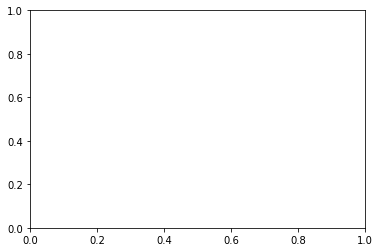

In [55]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(train[bin_label],train['Parameter5'],color='b',label='3',marker='.')
ax1.set_ylabel('Parameter5')
ax1.set_xlabel('bin_label')

ModuleNotFoundError: No module named 'featexp'